---

# Logistic Regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jghamdi/INDE577_Repo/blob/main/Supervised%20Learning/Logistic%20Regression%20Algorithm/Logistic%20Regression.ipynb)

In this notebook, we will delve into the realm of binary classification problems, focusing on the probabilistic approach. Specifically, we will model the problem using a single neuron and utilize the binary cross-entropy loss function. Similar to our previous exploration with single neuron linear regression, we will optimize our model parameters using stochastic gradient descent.

#### Motivation for Probabilistic Neuron Output
In traditional binary classification scenarios, such as when employing the perceptron single neuron model, we assumed that our data was linearly separable. However, this assumption may not always hold true in real-world scenarios. To address this limitation, we turn to the probabilistic output of our neuron. Let's explore this concept further by visualizing some examples.


---

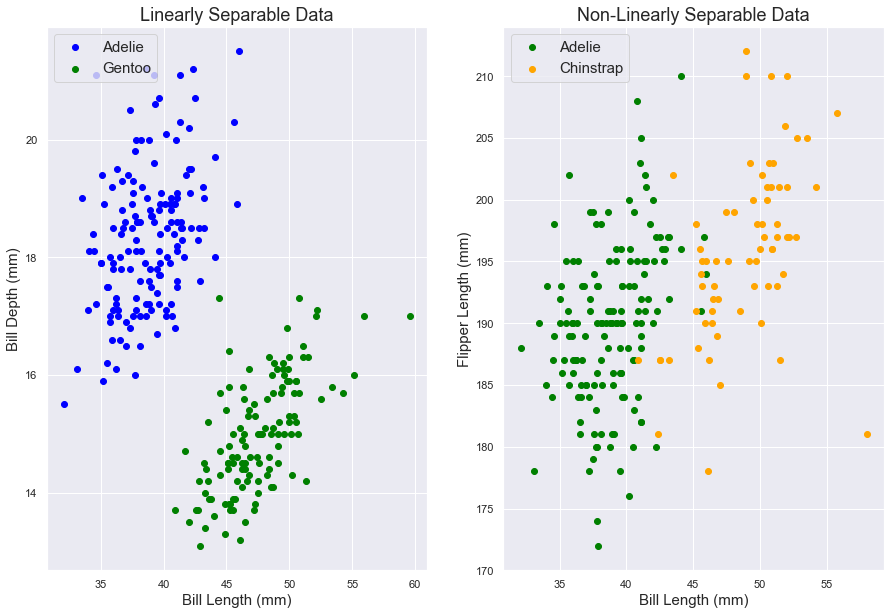

In [1]:
# Import all necessary packages.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boudaries.
from mlxtend.plotting import plot_decision_regions


# Set the Seaborn theme.
sns.set_theme()

# Read the penguins dataset into a pandas DataFrame object.
df = sns.load_dataset("penguins")

# Filter data for different penguin species.
adelie = df[df.species == "Adelie"]
gentoo = df[df.species == "Gentoo"]
chinstrap = df[df.species == "Chinstrap"]

# Create subplots for plotting.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Plot for linearly separable data.
ax1.scatter(adelie.bill_length_mm, 
            adelie.bill_depth_mm, 
            color="blue", 
            label="Adelie")
ax1.scatter(gentoo.bill_length_mm, 
            gentoo.bill_depth_mm, 
            color="green", 
            label="Gentoo")
ax1.set_xlabel("Bill Length (mm)", fontsize=15)
ax1.set_ylabel("Bill Depth (mm)", fontsize=15)
ax1.legend(fontsize=15, loc="upper left")
ax1.set_title("Linearly Separable Data", fontsize=18)

# Plot for non-linearly separable data.
ax2.scatter(adelie.bill_length_mm, 
            adelie.flipper_length_mm, 
            color="green", 
            label="Adelie")
ax2.scatter(chinstrap.bill_length_mm, 
            chinstrap.flipper_length_mm, 
            color="orange", 
            label="Chinstrap")
ax2.set_xlabel("Bill Length (mm)", fontsize=15)
ax2.set_ylabel("Flipper Length (mm)", fontsize=15)
ax2.legend(fontsize=15, loc="upper left")
ax2.set_title("Non-Linearly Separable Data", fontsize=18)

# Display the plot.
plt.show()


---

In our dataset, we encounter a similar scenario as depicted in the right figure above. It becomes evident that distinguishing between Adelie and Chinstrap penguins solely based on certain attributes like bill length and bill depth is challenging due to the overlap between these species' characteristics in the feature space.

Nevertheless, despite the non-linear separability of the data, intriguing patterns emerge. Notably, when considering only the bill length feature, we observe distinct regions where the probability of a penguin being of the Adelie species (when the bill length is less than 45) is higher than that of being of the Chinstrap species, and vice versa.

To facilitate binary classification, we assign labels: 0 for Adelie penguins and 1 for Chinstrap penguins. Subsequently, we visualize the distribution of penguin species solely based on the bill length attribute, as illustrated in the figure generated below:

---

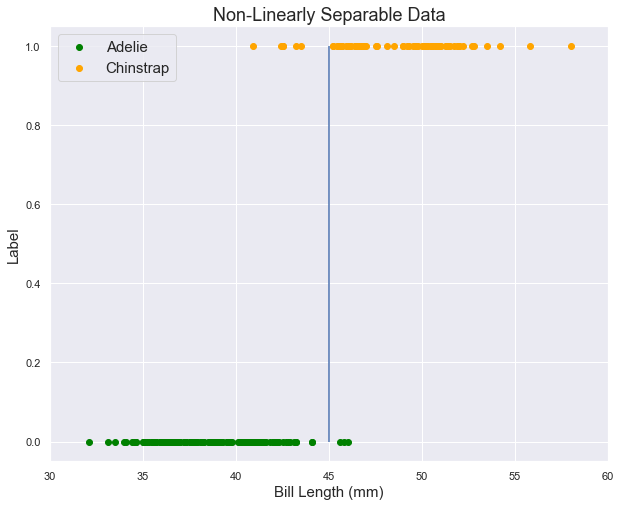

In [2]:
plt.figure(figsize=(10, 8))

# Set x-axis limits.
plt.xlim((30, 60))

# Plot data points for Adelie and Chinstrap penguins.
plt.scatter(adelie.bill_length_mm, 
            np.zeros(len(adelie)), 
            color="green", 
            label="Adelie")
plt.scatter(chinstrap.bill_length_mm, 
            np.ones(len(chinstrap)), 
            color="orange", 
            label="Chinstrap")

# Plot vertical line at x = 45.
plt.vlines(45, 0.0, 1.0)

# Set labels and title.
plt.xlabel("Bill Length (mm)", fontsize=15)
plt.ylabel("Label", fontsize=15)
plt.legend(fontsize=15, loc="upper left")
plt.title("Non-Linearly Separable Data", fontsize=18)

plt.show()


---

### Building a Probabilistic Single Neuron Model
In this section, we transition from deterministic classification to probabilistic classification using a single neuron model. Instead of directly predicting class labels, our neuron will output probabilities representing the likelihood of each class.

#### Understanding the Sigmoid Activation Function
In our quest to design a probabilistic single neuron, the choice of activation function plays a pivotal role. We opt for the sigmoid activation function, defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

This function exhibits desirable properties for our task. Notably, it produces outputs in the range of (0, 1), making it ideal for interpreting as probabilities. Additionally, its smooth, "S"-shaped curve facilitates seamless transitions in probability values as input features vary.

To gain a visual understanding of the sigmoid function's behavior, execute the provided code snippet in the following cell:

---

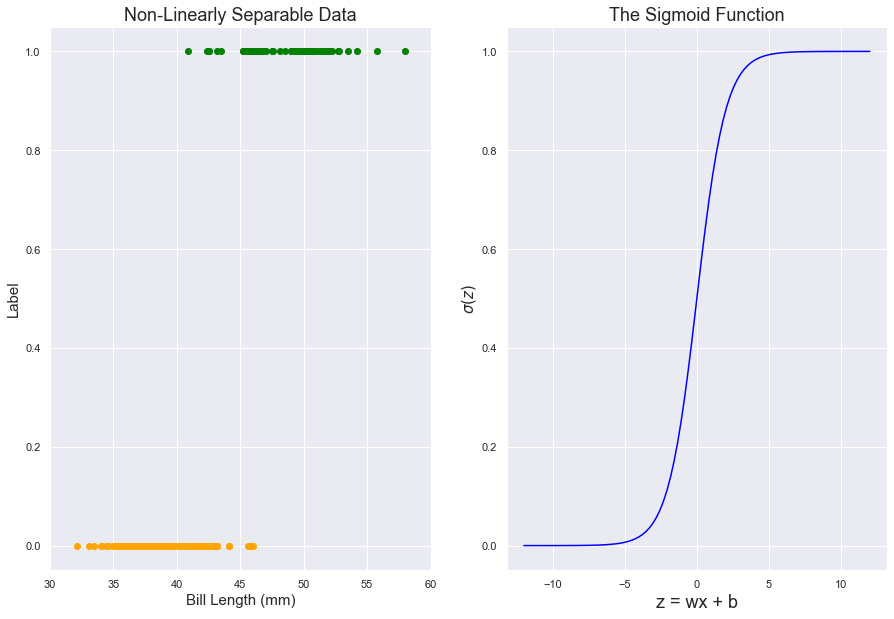

In [3]:
def sigmoid(z):
    """
    Compute the sigmoid function for the given input.

    Parameters:
    z (numpy.ndarray): The input array.

    Returns:
    numpy.ndarray: The output of the sigmoid function for each element of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

# Create subplots for visualizing data and sigmoid function.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Adjust x-axis limits for ax1 subplot.
ax1.set_xlim((30, 60))

# Scatter plot for Gentoo and Chinstrap penguins in ax1.
ax1.scatter(adelie.bill_length_mm, 
            np.zeros(len(adelie)), 
            color="orange", 
            label="Adelie")
ax1.scatter(chinstrap.bill_length_mm, 
            np.ones(len(chinstrap)), 
            color="green", 
            label="Chinstrap")
ax1.set_xlabel("Bill Length (mm)", fontsize=15)
ax1.set_ylabel("Label", fontsize=15)
ax1.set_title("Non-Linearly Separable Data", fontsize=18)

# Define domain for sigmoid function.
domain = np.linspace(-12.0, 12.0, 100)

# Plot sigmoid function in ax2.
ax2.plot(domain, 
         sigmoid(domain), 
         color="blue", 
         label="$\sigma$(z)")
ax2.set_xlabel("z = wx + b", fontsize=18)
ax2.set_ylabel("$\sigma(z)$", fontsize=15)
ax2.set_title("The Sigmoid Function", fontsize=18)

plt.show()



---

We can see that the two figures generated above illustrate the need for a logistic regression model. Bill pre-activation values might map bill length measurements to the correct inputs for the sigmoid function, producing post-activation values that describe the probability of observing an adelie or chinstrap penguin.

#### Binary Cross Entropy Loss Function
We introduce the binary cross entropy loss function to train our single neuron. By maximizing the probability of correct classification, we seek to solve the optimization problem and derive the loss function.

#### The Logistic Regression Single Neuron Model
We depict the logistic regression single neuron model, which consists of a sigmoid activation function and a cost function based on binary cross entropy loss.

#### Calculating the Gradient
We calculate the gradient of the binary cross entropy loss function with respect to the model parameters (weights and bias). The resulting partial derivatives allow us to implement stochastic gradient descent for training the model.

#### Conclusion
With a complete understanding of logistic regression and the single neuron model, we're ready to implement our custom neuron class for training logistic regression models on the Palmer Penguin dataset.

In [4]:
class CustomNeuron(object):
    """
    A class used to represent a single artificial neuron. 

    ...

    Attributes
    ----------
    activation_function : function
        The activation function applied to the preactivation linear combination.
    
    cost_function : function
        The cost function used to measure model performance.

    w_ : numpy.ndarray
        The weights and bias of the single neuron. The last entry being the bias. 
        This attribute is created when the train method is called.

    errors_: list
        A list containing the mean sqaured error computed after each iteration 
        of stochastic gradient descent per epoch. 

    Methods
    -------
    train(self, X, y, alpha = 0.005, epochs = 50)
        Iterates the stochastic gradient descent algorithm through each sample 
        a total of epochs number of times with learning rate alpha. The data 
        used consists of feature vectors X and associated labels y. 

    predict(self, X)
        Uses the weights and bias, the feature vectors in X, and the 
        activation_function to make a y_hat prediction on each feature vector. 
    """
    def __init__(self, activation_function, cost_function):
        self.activation_function = activation_function
        self.cost_function = cost_function

    def train(self, X, y, alpha = 0.005, epochs = 50):
   
        self.w_ = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        N = X.shape[0]

        for _ in range(epochs):
            errors = 0
            for xi, target in zip(X, y):
                error = (self.predict(xi) - target)
                self.w_[:-1] -= alpha*error*xi
                self.w_[-1] -= alpha*error
                #errors += .5*((self.predict(xi) - target)**2)
                errors += self.cost_function(self.predict(xi), target)
            self.errors_.append(errors/N)
        return self

    def predict(self, X):
        preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
        return self.activation_function(preactivation)

    def plot_cost_function(self):
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.errors_) + 1), 
                self.errors_,
                label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()



---

Now that we have our CustomNeuron class, we take a step closer to molding our model to fit our dataset. However, before we proceed to instantiate an instance of the CustomNeuron class, we must craft a binary cross-entropy loss function. Once this foundational task is completed, we can gracefully summon an instance of our meticulously crafted CustomNeuron. Following this invocation, we embark on the journey of data preparation, where we convert the bill length measurements of the Adelie and Chinstrap penguins into a numpy.ndarray. This transformation is not mere formality; it is a crucial step, especially when our features consist of singular measurements. Subsequently, we carve out a target vector y, a numpy.ndarray that assigns the labels 0 and 1 to the Adelie and Chinstrap species, respectively.

With our feature vector and target vector elegantly poised, we orchestrate their synchronized dance within the CustomNeuron.train() method. This method, wielding the finesse of stochastic gradient descent, guides our logistic single neuron through the labyrinth of data, iteratively refining its parameters until convergence. With bated breath, we execute the following symphony of code, allowing our meticulously crafted CustomNeuron to engage in the timeless dance of learning and adaptation.

---

In [5]:
def cross_entropy_loss(y_hat, y):
    """
    Compute the cross entropy loss between predicted and true labels.

    Parameters:
    y_hat : numpy.ndarray
        Predicted labels.
    y : numpy.ndarray
        True labels.

    Returns:
    float
        Cross entropy loss.
    """
    return -y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)

# Instantiate CustomNeuron with sigmoid activation function and cross entropy loss.
node = CustomNeuron(sigmoid, cross_entropy_loss)

# Remove rows with NA values.
df_cleaned = df.dropna(subset=['bill_length_mm', 'species'])

# Prepare data for chinstrap and adelie penguins.
X = df_cleaned[['bill_length_mm']].values
X = X.reshape(-1, 1)
y = np.where(df_cleaned['species'].isin(['Adelie', 'Chinstrap']), 0, 1)


# Train the neuron.
node.train(X, y, alpha=0.01, epochs=500_000)  # Adjust alpha and epochs as needed.


---

Now that we have trained the node variable, we can visualize the binary cross-entropy loss for each epoch by plotting the values stored in the `CustomNeuron.errors_`  attribute. This can be accomplished by running the provided code snippet in the cell below.

---

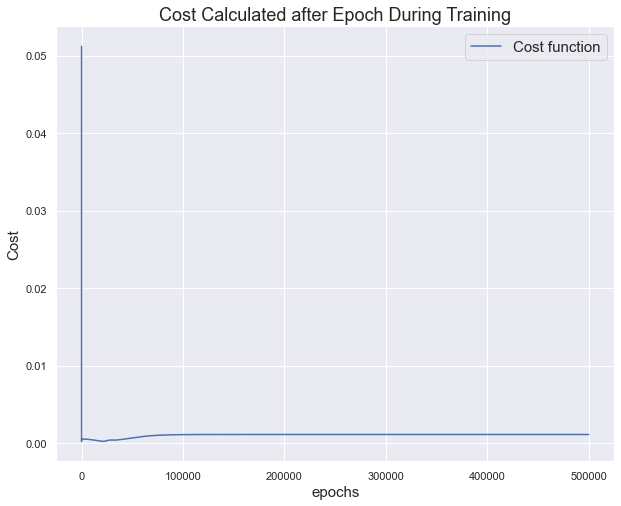

In [6]:
# Plot the cost function.
node.plot_cost_function()
plt.show()

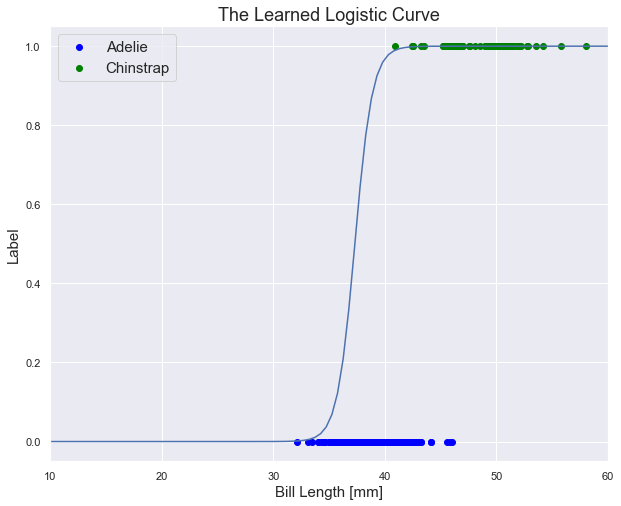

In [7]:
# Create a figure for plotting with a specific size.
plt.figure(figsize=(10, 8))

# Set the x-axis limit for better visualization.
plt.xlim((10, 60))

# Plot Adelie penguins' bill length with label 0.
plt.scatter(adelie.bill_length_mm,
            np.zeros(len(adelie)),
            color="blue",
            label="Adelie")
# Plot Chinstrap penguins' bill length with label 1.
plt.scatter(chinstrap.bill_length_mm,
            np.ones(len(chinstrap)),
            color="green",
            label="Chinstrap")
# Generate a range of bill length values for prediction.
domain = np.linspace(10, 60, 100)
# Plot the logistic regression curve using the model's predict function.
plt.plot(domain, node.predict(domain.reshape(-1, 1)))
plt.xlabel("Bill Length [mm]", fontsize=15)
plt.ylabel("Label", fontsize=15)
plt.legend(fontsize=15, loc="upper left")

# Set the title of the plot.
plt.title("The Learned Logistic Curve", fontsize=18)

# Display the plot.
plt.show()



In [8]:
# Predict the output labels for the input data X using the trained model node.
node.predict(X)


array([0.90664604, 0.94166124, 0.97806364, 0.3154423 , 0.92603818,
       0.88281287, 0.91685476, 0.01667612, 0.99741782, 0.65073511,
       0.65073511, 0.99194584, 0.83730653, 0.03101046, 0.28868003,
       0.85387578, 0.99862999, 0.02422276, 0.9999839 , 0.65073511,
       0.62134612, 0.14296885, 0.75589374, 0.86902153, 0.07223289,
       0.98490896, 0.98290022, 0.67902143, 0.98290022, 0.94166124,
       0.46511534, 0.94166124, 0.9896408 , 0.23942836, 0.91685476,
       0.86902153, 0.99799589, 0.59103833, 0.95939446, 0.26331493,
       0.98825439, 0.15924704, 0.99982023, 0.40280809, 0.9482594 ,
       0.99194584, 0.56002245, 0.15924704, 0.9982345 , 0.9482594 ,
       0.97189818, 0.05050279, 0.99741782, 0.02741318, 0.9944836 ,
       0.89532697, 0.98490896, 0.26331493, 0.59103833, 0.11457277,
       0.99374122, 0.59103833, 0.99194584, 0.23942836, 0.99571573,
       0.09121637, 0.99194584, 0.14296885, 0.99667357, 0.00785282,
       0.95414763, 0.9482594 , 0.99997925, 0.09121637, 0.99906

---

When utilizing the trained weights and bias of our logistic single neuron to predict a class on a given measurement, we need to convert the predicted probabilities to binary labels. This conversion can be achieved by applying the `numpy.rint()` method to the output `numpy.ndarray` returned by the `CustomNeuron.predict()` method.

Additionally, we can evaluate the classification error over our training data using the formula:

$$
E_c = \frac{1}{N}\sum_{i=1}^{N}[\hat{y}^{(i)} \neq y^{(i)}],
$$

where $[\hat{y}^{(i)} \neq y^{(i)}] = 1$ if $\hat{y}^{(i)} \neq y^{(i)}$, and zero otherwise.

To visualize this classification error, execute the provided code snippet in the cell below.


In [9]:
np.rint(node.predict(X)) != y

array([ True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True, False,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False,  True, False,  True, False,  True, False,  True,  True,
        True, False,  True,  True, False, False,  True, False,  True,
       False, False, False,  True, False, False,  True,  True, False,
        True, False,  True, False,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,

In [10]:
# Calculate the classification error by comparing the rounded predictions to the true labels.
classification_error = (np.rint(node.predict(X)) != y).astype(int)

# Compute and print the classification error rate.
print(f"Classification Error = {sum(classification_error)/ len(y)}")

Classification Error = 0.5029239766081871


---

Now, let's visualize the decision boundary learned by our model using the trained weights and bias. 

---

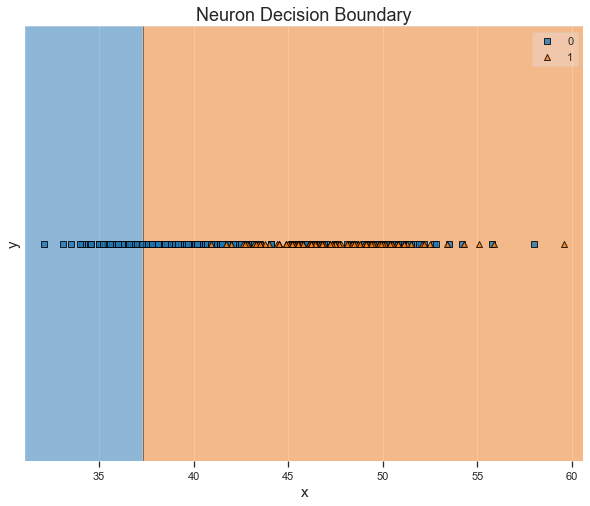

In [11]:
# Plot the decision boundary of the logistic regression model.
node.plot_decision_boundary(X, y)

# Display the plot.
plt.show()


---

### Exploring Logistic Regression with Multiple Inputs
Up until now, we've only considered a single feature measurement as input for our logistic regression single neuron model. But what if we incorporate multiple measurements? For instance, we could include both bill length and bill width. With two inputs, our model takes on a more intricate form, as illustrated below.


Now, let's proceed by creating an instance of the CustomNeuron model using bill length and flipper length measurements as inputs. We'll train this model with the same learning rate and number of epochs as the variable node, and then compare the cost function over epochs between the two models. 

---

<ipython-input-5-ec76398aa745>:15: RuntimeWarning: divide by zero encountered in log
  return -y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)
<ipython-input-5-ec76398aa745>:15: RuntimeWarning: invalid value encountered in scalar multiply
  return -y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)


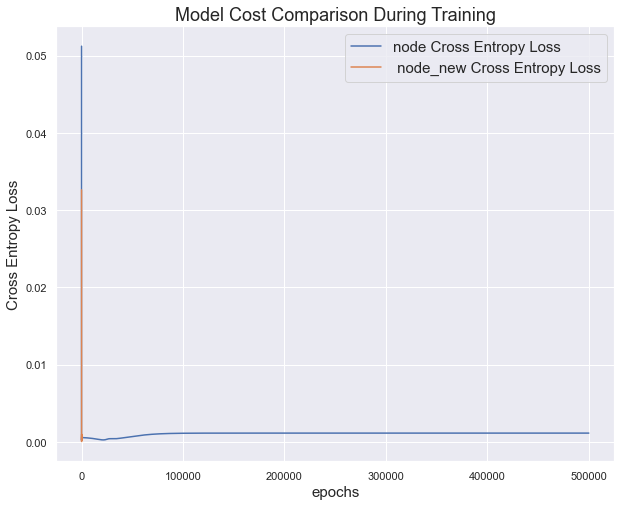

In [12]:

node_new = CustomNeuron(sigmoid, cross_entropy_loss)
# Prepare data for chinstrap and adelie penguins.
X_new = df_cleaned[['bill_length_mm', 'bill_depth_mm']].values

# Train the new single neuron model on the new feature vectors.
node_new.train(X_new, y, alpha = 0.01, epochs = 200_000)


plt.figure(figsize = (10, 8))
plt.plot(range(1, len(node.errors_) + 1), 
         node.errors_,
         label = "node Cross Entropy Loss")
plt.plot(range(1, len(node_new.errors_) + 1), 
         node_new.errors_,
         label = " node_new Cross Entropy Loss")
plt.xlabel("epochs", fontsize = 15)
plt.ylabel("Cross Entropy Loss", fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Model Cost Comparison During Training", fontsize = 18)


plt.show()

---


As we can see by the figures generated above, using two features results in a lower cost function (in this particular instance) with the same learning rate and number of epochs. Finally, let us visualize the decision boundary generated by the trained weights and bias of ```node_new``` by running the following code in the cell below. After running notice that even with the logistic regression single neuron, we are still learning a linearly seperating hyperplane.  


---

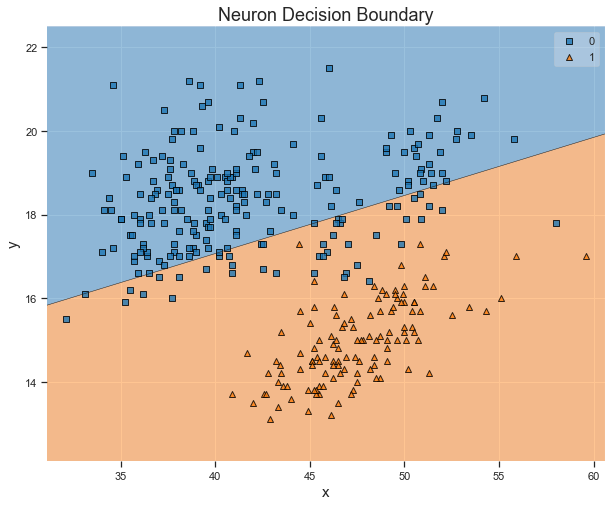

In [13]:
# Visualize the decision boundary using the trained weights and bias of node_new.
node_new.plot_decision_boundary(X_new, y)


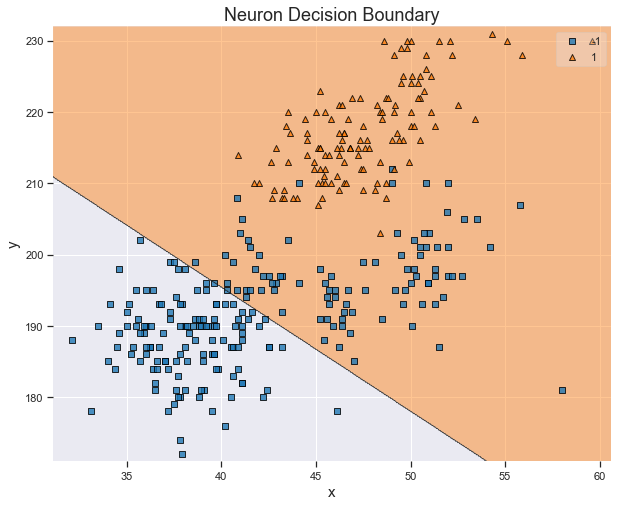

In [17]:
# Define the sign function for binary classification.
def sign(z):
    """
    Computes the sign of the input.

    Parameters:
        z (float): The input value.

    Returns:
        int: The sign of the input value.
    """
    return np.sign(z)

# Define the Mean Squared Error (MSE) loss function.
def MSE(y_hat, y):
    """
    Computes the Mean Squared Error (MSE) between predicted and actual values.

    Parameters:
        y_hat (float): Predicted value.
        y (float): Actual value.

    Returns:
        float: The Mean Squared Error (MSE) between y_hat and y.
    """
    return .5*(y_hat - y)**2


# Instantiate a new single neuron.
node_three = CustomNeuron(sign, MSE)

# Create a numpy.ndarray of bill length and flipper length values for
# the adelie and chinstrap penguin, respectively. 
X_three = df_cleaned[["bill_length_mm", "flipper_length_mm"]].values

y_three = y = np.where(df_cleaned['species'].isin(['Adelie', 'Chinstrap']), -1, 1)


# Train the new single neuron model on the new feature vectors.
node_three.train(X_three, y_three, alpha = 0.001, epochs = 500_000)

node_three.plot_decision_boundary(X_three, y_three)
plt.show()

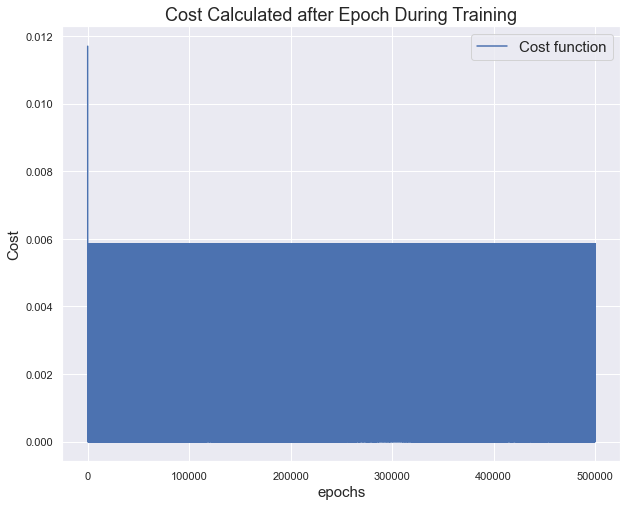

In [18]:
# Visualize the cost function over epochs for the new single neuron model.
node_three.plot_cost_function()


<ipython-input-17-45d25cde290e>:26: RuntimeWarning: overflow encountered in scalar power
  return .5*(y_hat - y)**2
<ipython-input-4-0f9cf6022447>:48: RuntimeWarning: invalid value encountered in subtract
  self.w_[:-1] -= alpha*error*xi
<ipython-input-4-0f9cf6022447>:49: RuntimeWarning: invalid value encountered in scalar subtract
  self.w_[-1] -= alpha*error


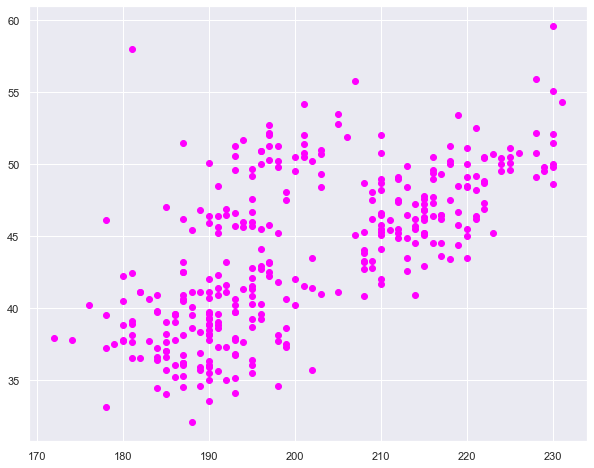

In [19]:
# Define the linear activation function.
def linear(z):
    """
    Linear activation function.
    
    Parameters:
        z (float): The preactivation value.
        
    Returns:
        float: The preactivation value itself.
    """
    return z

# Instantiate a new single neuron with linear activation function and MSE loss.
node_four = CustomNeuron(linear, MSE)

# Extract feature and target vectors from the dataset.
X_four = df_cleaned["flipper_length_mm"].values
X_four = X_four.reshape(-1, 1)
y_four = df_cleaned["bill_length_mm"].values

# Train the new single neuron model on the feature vectors.
node_four.train(X_four, y_four, alpha=0.001, epochs=50_000)

# Plot the original data points and the regression line predicted by the trained model.
plt.figure(figsize=(10, 8))
plt.scatter(X_four, y_four, label="adelie", color="magenta")

# Generate domain values for the regression line.
domain = np.linspace(np.min(X_four), np.max(X_four), 50)
plt.plot(domain, node_four.predict(domain.reshape(-1, 1)), label="regression line")
plt.show()
